In [288]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [289]:
#load datasets
df = pd.read_csv('My Diabets CSV.csv')
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [290]:
df.shape

(2768, 9)

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2768 non-null   int64  
 1   Glucose                   2768 non-null   int64  
 2   BloodPressure             2768 non-null   int64  
 3   SkinThickness             2768 non-null   int64  
 4   Insulin                   2768 non-null   int64  
 5   BMI                       2768 non-null   float64
 6   DiabetesPedigreeFunction  2768 non-null   float64
 7   Age                       2768 non-null   int64  
 8   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 194.8 KB


In [292]:
 # checking missing values
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [293]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000
mean,3.742775,121.102601,69.134393,20.824422,80.127890,32.137392,0.471193,33.132225,0.343931
std,3.323801,32.036508,19.231438,16.059596,112.301933,8.076127,0.325669,11.777230,0.475104
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,37.000000,32.200000,0.375000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.625000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,846.000000,80.600000,2.420000,81.000000,1.000000


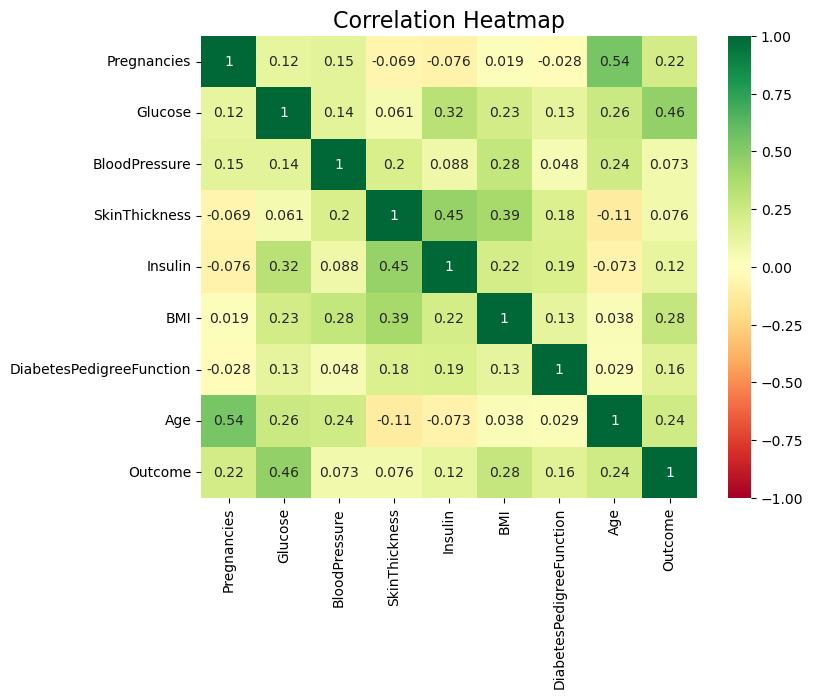

In [294]:
# Correlation features
plt.figure(figsize=(8,6))
corr = df.corr()#.as_data_frame()
corr.index = df.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [295]:
 # target variable
X = df.drop(['Outcome'],axis=1)
y = df['Outcome']


In [296]:
#Split into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


In [297]:
X_train.shape, X_test.shape

((2214, 8), (554, 8))

In [298]:
# Random search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#Define hyperparameters distributions
param_dist ={
    'n_estimators':randint(100,500),
    'max_depth':randint(5,15),
    'min_samples_split':randint(2,10),
    'min_samples_leaf':randint(1,10),
    'max_features':['sqrt','log2']
}

In [299]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

# classifier
model = RandomForestClassifier(random_state=42)

#Perform randomized search
random_search =RandomizedSearchCV(model, param_dist, cv=5, scoring='neg_brier_score',n_iter=10)
random_search.fit(X_train, y_train)

# Calibrate best model
calibrated_model = CalibratedClassifierCV(random_search.best_estimator_, method='sigmoid', cv=5)
calibrated_model.fit(X_train, y_train)

# Predict test results
#y_pred = model.predict(X_test)

CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(max_depth=13,
                                                        max_features='log2',
                                                        min_samples_leaf=6,
                                                        min_samples_split=3,
                                                        n_estimators=256,
                                                        random_state=42))

In [300]:
from sklearn.metrics import brier_score_loss, roc_auc_score, accuracy_score

#Predict probabilities on test set
y_pred_proba = calibrated_model.predict_proba(X_test)[:,1]

# Evaluate calibration
brier_score = brier_score_loss(y_test, y_pred_proba)
print("Brier Score:", brier_score)

#Evaluation ROC-AUC
roc_auc =roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC:", roc_auc)

#Evaluate accuracy
y_pred_class = calibrated_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Brier Score: 0.059148937746165885
ROC-AUC: 0.9777906304222094
Accuracy: 0.9097472924187726


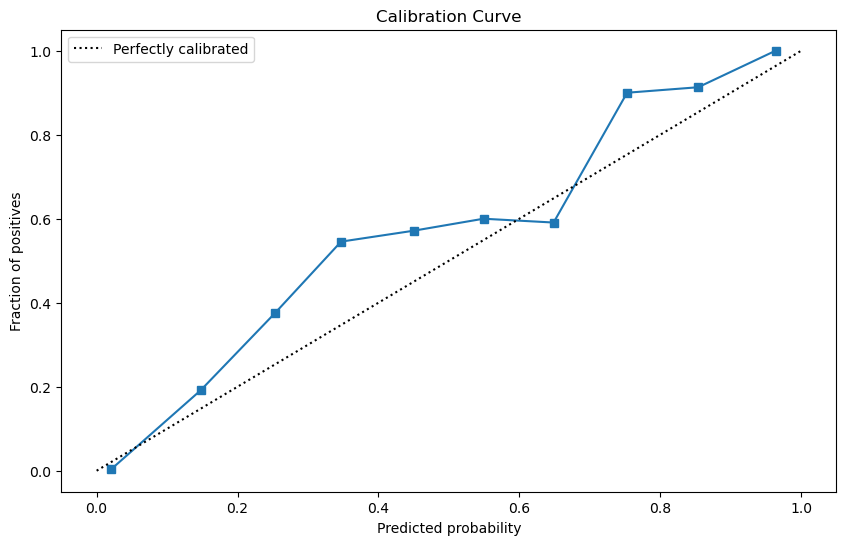

In [301]:
from sklearn.calibration import calibration_curve

# calibration plot
plt.figure(figsize=(10,6))
fraction_of_positives, mean_predicted_values = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.plot(mean_predicted_values, fraction_of_positives, 's-')
plt.plot([0,1],[0,1],'k:', label ='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()

plt.show()

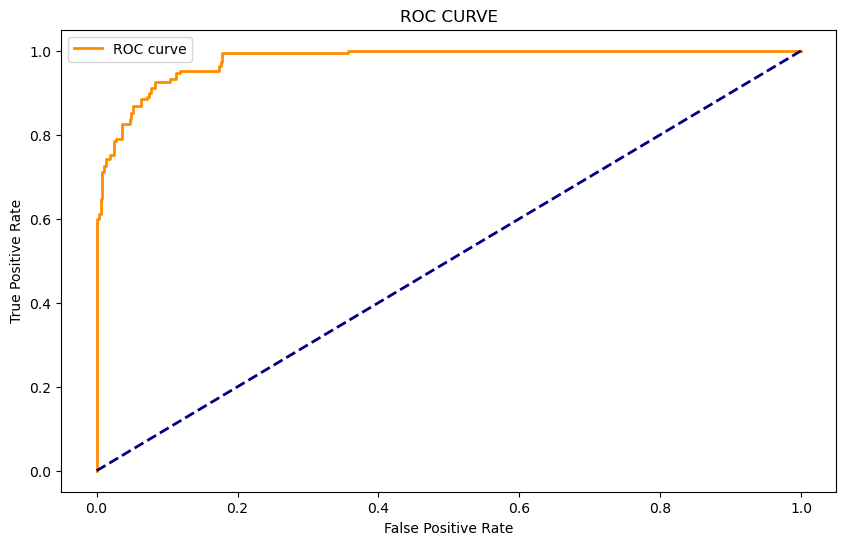

In [302]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize = (10,6))
plt.plot(fpr, tpr, color ='darkorange', lw=2, label='ROC curve')
plt.plot([0,1],[0,1], color ='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()

In [304]:
matrix = confusion_matrix(y_test, y_pred_class)
print(matrix)

[[347  17]
 [ 33 157]]


In [305]:
report = classification_report(y_test, y_pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       364
           1       0.90      0.83      0.86       190

    accuracy                           0.91       554
   macro avg       0.91      0.89      0.90       554
weighted avg       0.91      0.91      0.91       554



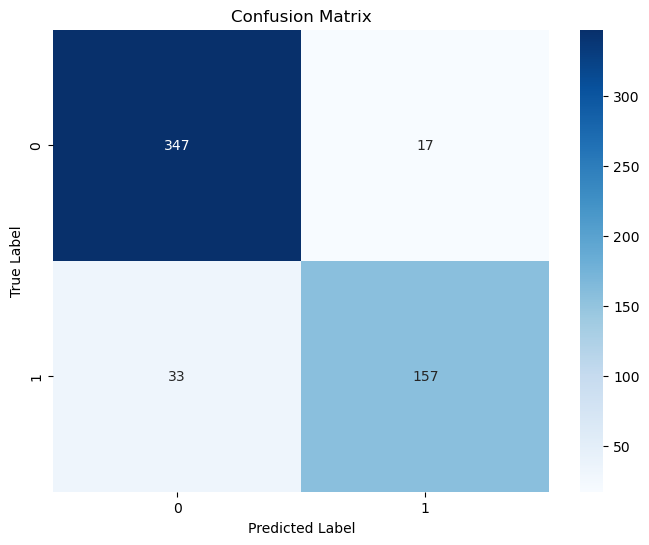

In [306]:
#Confusion Matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [308]:
from sklearn.metrics import cohen_kappa_score, mean_squared_error
print("Cohen's kappa:",cohen_kappa_score(y_test, y_pred_class))
print("MSE:", mean_squared_error(y_test, y_pred_class))


Cohen's kappa: 0.7956262542793059
MSE: 0.09025270758122744


In [315]:
import pickle

#save model to file
with open('DiabetsRiskModel.pkl','wb') as f: pickle.dump(calibrated_model,f)